In [2]:
%matplotlib widget

In [3]:
%load_ext autoreload

In [4]:
import numba
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax
jax.config.update("jax_enable_x64", True)

In [5]:
%autoreload
from microscope_calibration.common.model import (
    Parameters4DSTEM, Model4DSTEM, Result4DSTEM, PixelYX, CoordXY, identity, rotate, scale, flip_y,
    DescanError
)
from microscope_calibration.util.stem_overfocus_sim import smiley, project
from microscope_calibration.common.stem_overfocus import (
    get_backward_transformation_matrix, get_detector_correction_matrix, correct_frame, project_frame_backwards
)

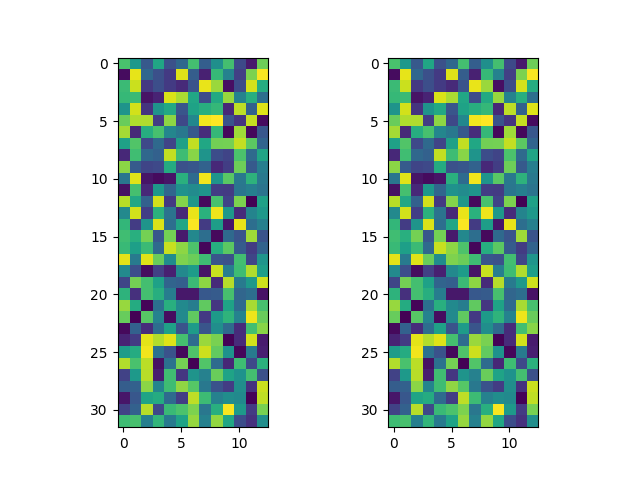

In [9]:
# 1:1 size mapping between detector and specimen
params = Parameters4DSTEM(
    overfocus=1,
    scan_pixel_pitch=1,
    camera_length=1,
    detector_pixel_pitch=2,
    semiconv=np.pi/2,
    scan_center=PixelYX(x=7.1, y=16.),
    scan_rotation=0.,
    flip_y=False,
    detector_center=PixelYX(x=7.1, y=16.),
    descan_error=DescanError()
)
obj = np.random.random((32, 13))
res = np.zeros_like(obj)
mat = get_backward_transformation_matrix(rec_params=params)
project_frame_backwards(
    frame=obj,
    source_semiconv=np.pi/2,
    mat=mat,
    scan_y=16,
    scan_x=7,
    image_out=res,
)

fig, axes = plt.subplots(1, 2, squeeze=False)
axes[0, 0].imshow(obj)
axes[0, 1].imshow(res)
#np.allclose(obj, res)

In [147]:
%autoreload
scan_pixel_pitch = 0.1
detector_pixel_pitch = 0.2
overfocus = 1.
camera_length = 1.
propagation_distance = overfocus + camera_length
obj_half_size = 16
angle = np.arctan2(obj_half_size*detector_pixel_pitch/2 + 0.00314157, propagation_distance)

def map_coord(inp):
    cy = obj.shape[0] / 2
    cx = obj.shape[1] / 2
    inp_vec = jnp.array((inp.y, inp.x))
    y, x = rotate(-np.pi/2) @ scale(1/scan_pixel_pitch) @ inp_vec
    return PixelYX(y=y+cy + 2, x=x+cx - 3)

# map_coord = None

params = Parameters4DSTEM(
    overfocus=overfocus,
    scan_pixel_pitch=scan_pixel_pitch,
    camera_length=camera_length,
    detector_pixel_pitch=detector_pixel_pitch,
    semiconv=angle,
    scan_center=PixelYX(x=0., y=0.),
    scan_rotation=np.pi/2,
    flip_y=False,
    detector_center=PixelYX(x=2* obj_half_size, y=2* obj_half_size),
    detector_rotation=np.pi/2,
    descan_error=DescanError(
        offpxi=detector_pixel_pitch,
        offpyi=detector_pixel_pitch * 2,
        offsxi=-1 * detector_pixel_pitch/camera_length,
        offsyi=-1 * detector_pixel_pitch/camera_length,
        pxo_pxi=1 * detector_pixel_pitch/scan_pixel_pitch,
        pyo_pyi=1 * detector_pixel_pitch/scan_pixel_pitch,
        sxo_pxi=-2 * detector_pixel_pitch/scan_pixel_pitch/camera_length,
        syo_pyi=-1 * detector_pixel_pitch/scan_pixel_pitch/camera_length,
    )
)

params_ref = Parameters4DSTEM(
    overfocus=overfocus,
    scan_pixel_pitch=scan_pixel_pitch,
    camera_length=camera_length,
    detector_pixel_pitch=detector_pixel_pitch * 2,
    semiconv=angle,
    scan_center=PixelYX(x=0., y=0.),
    scan_rotation=np.pi/2,
    flip_y=True,
    detector_center=PixelYX(x=obj_half_size * 2 - 1, y=obj_half_size * 2 + 3),
    detector_rotation=0.,
    descan_error=DescanError()
)

params_ref_manual = Parameters4DSTEM(
    overfocus=overfocus,
    scan_pixel_pitch=scan_pixel_pitch * 2,
    camera_length=camera_length,
    detector_pixel_pitch=detector_pixel_pitch * 2,
    semiconv=angle,
    scan_center=PixelYX(x=obj_half_size, y=obj_half_size),
    scan_rotation=np.pi/23,
    flip_y=True,
    detector_center=PixelYX(x=obj_half_size * 2 - 1, y=obj_half_size * 2 + 3),
    detector_rotation=0.,
    descan_error=DescanError()
)


mat = get_detector_correction_matrix(rec_params=params, ref_params=params_ref_manual)

In [148]:
%autoreload
obj = smiley(obj_half_size * 2) # np.ones((obj_half_size * 2, obj_half_size * 2))

projected = project(
    image=obj,
    detector_shape=(obj_half_size * 4, obj_half_size * 4),
    scan_shape=(obj_half_size * 2, obj_half_size * 2),
    sim_params=params,
    specimen_to_image=map_coord
)

ref = obj.copy()
ys, xs = np.ogrid[:obj.shape[0], :obj.shape[1]]
ys -= obj_half_size
xs -= obj_half_size
dist = np.sqrt(ys**2 + xs**2)

ref[dist > obj_half_size/2 + 0.00314157] = 0

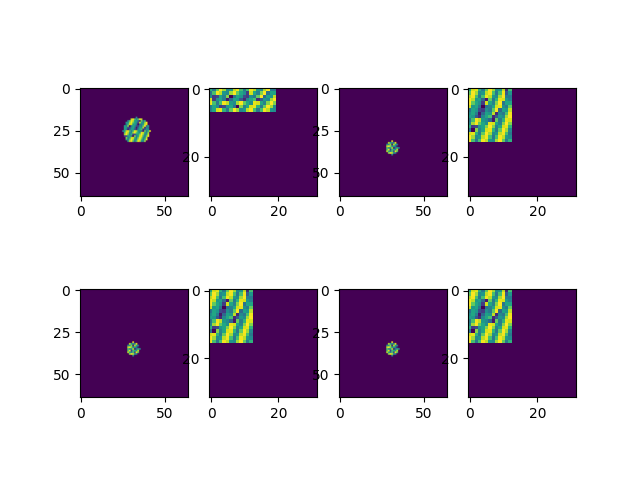

In [149]:
%autoreload

out = np.zeros_like(projected)
for scan_y in range(out.shape[0]):
    for scan_x in range(out.shape[1]):
        correct_frame(
            frame=projected[scan_y, scan_x],
            mat=mat,
            scan_y=scan_y,
            scan_x=scan_x,
            detector_out=out[scan_y, scan_x],
        )

projected_ref = project(
    image=obj,
    detector_shape=(obj_half_size * 4, obj_half_size * 4),
    scan_shape=(obj_half_size * 2, obj_half_size * 2),
    sim_params=params_ref,
    specimen_to_image=map_coord,
)


scan_y = 7
scan_x = 9

                    
fig, axes = plt.subplots(2, 4, squeeze=False)

axes[0, 0].imshow(projected[scan_y, scan_x])
axes[0, 1].imshow(projected[:, :, obj_half_size * 2, obj_half_size * 2])
axes[0, 2].imshow(out[scan_y, scan_x])
axes[0, 3].imshow(out[:, :, obj_half_size* 2, obj_half_size * 2])

axes[1, 0].imshow(projected_ref[scan_y, scan_x])
axes[1, 1].imshow(projected_ref[:, :, obj_half_size * 2, obj_half_size * 2])
axes[1, 2].imshow(out[scan_y, scan_x])
axes[1, 3].imshow(out[:, :, obj_half_size * 2, obj_half_size * 2])


In [150]:
clip = 1
clip2 = 1
np.allclose(projected_ref, out)

True

In [237]:

np.allclose(projected_ref[scan_y, scan_x, clip2:-clip2, clip2:-clip2], out[scan_y, scan_x, clip2:-clip2, clip2:-clip2])

True

In [229]:
projected_ref[scan_y, scan_x] - out[scan_y, scan_x]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(32, 32), dtype=float32)

(32, 32, 64, 64)


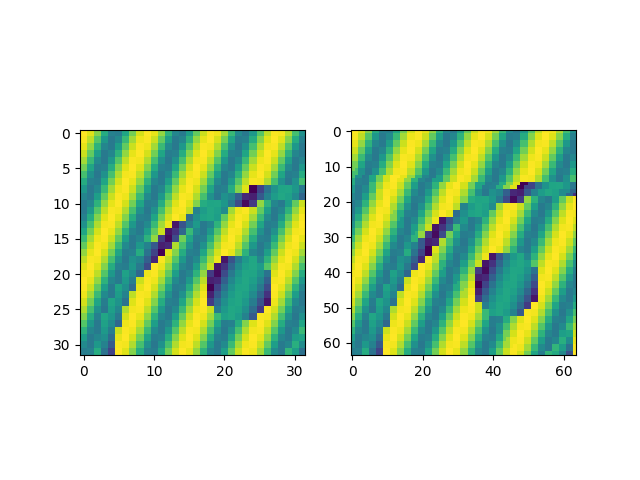

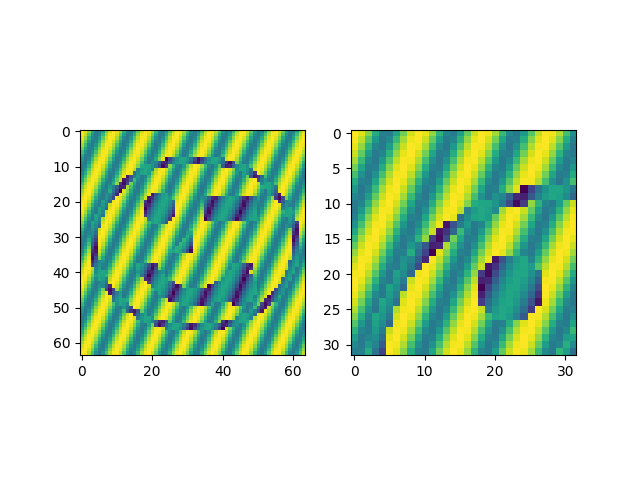

In [182]:
detector_rotation = 0.
scan_rotation = 0.

params = Parameters4DSTEM(
    overfocus=1,
    scan_pixel_pitch=2,
    camera_length=1,
    detector_pixel_pitch=2,
    semiconv=np.pi/2,
    scan_center=PixelYX(x=16., y=16.),
    scan_rotation=0.,
    flip_y=False,
    detector_center=PixelYX(x=32, y=32.),
    detector_rotation=0.,
    descan_error=DescanError()
)
obj = smiley(64)
res = np.zeros((32, 32))

# def map_coord(inp):
#     cy = obj.shape[0] / 2
#     cx = obj.shape[1] / 2
#     inp_vec = jnp.array((inp.y, inp.x))
#     y, x = scale(1) @ inp_vec
#     return PixelYX(y=y+cy, x=x+cx)

map_coord = None

projected = project(
    image=obj,
    scan_shape=((32, 32)),
    detector_shape=((64, 64)),
    sim_params=params,
    specimen_to_image=map_coord,
)

print(projected.shape)

fig, axes = plt.subplots(1, 2, squeeze=False)
axes[0, 0].imshow(projected[:, :, 32, 32])
axes[0, 1].imshow(projected[16, 16])

mat = get_backward_transformation_matrix(
    rec_params=params,
    specimen_to_image=map_coord
)
project_frame_backwards(
    frame=projected[16, 16],
    source_semiconv=np.pi/2,
    mat=mat,
    scan_y=16,
    scan_x=16,
    image_out=res,
)




fig, axes = plt.subplots(1, 2, squeeze=False)

axes[0, 0].imshow(obj)
axes[0, 1].imshow(res)


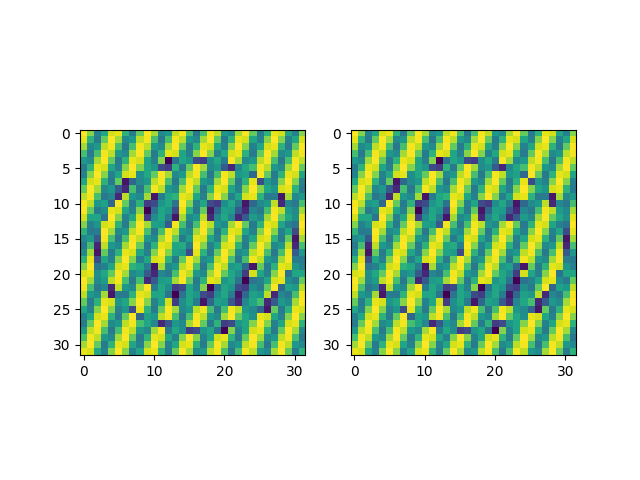

In [39]:
params = Parameters4DSTEM(
    overfocus=1,
    scan_pixel_pitch=1,
    camera_length=1,
    detector_pixel_pitch=2,
    semiconv=np.pi/2,
    scan_center=PixelYX(x=16, y=16.),
    scan_rotation=0.,
    flip_y=False,
    detector_center=PixelYX(x=16, y=16.),
    detector_rotation=np.pi/2,
    descan_error=DescanError()
)
obj = smiley(32)
res = project(
    image=obj,
    detector_shape=(32, 32),
    scan_shape=(32, 32),
    sim_params=params,
)
fig, axes = plt.subplots(1, 2)
axes[0].imshow(obj)
axes[1].imshow(np.rot90(res[16, 15], k=-1)) 
#assert_allclose(obj, np.rot90(res[15, 16], k=-1))

In [23]:
trans = rotate(np.pi/1.23) @ scale(0.23) @ flip_y()
cis = jnp.linalg.inv(trans)

In [24]:
trans, cis

(Array([[ 0.19144175,  0.12747571],
        [ 0.12747571, -0.19144175]], dtype=float64),
 Array([[ 3.61893665,  2.40974878],
        [ 2.40974878, -3.61893665]], dtype=float64))

In [25]:
cis2 = flip_y() @ scale(1/0.23) @ rotate(-np.pi/1.23)
cis2

Array([[ 3.61893665,  2.40974878],
       [ 2.40974878, -3.61893665]], dtype=float64)

In [26]:
I = np.eye(2, dtype=trans.dtype)
cis3 = jnp.linalg.solve(trans, I)
cis3

Array([[ 3.61893665,  2.40974878],
       [ 2.40974878, -3.61893665]], dtype=float64)

In [27]:
cis3

Array([[ 3.61893665,  2.40974878],
       [ 2.40974878, -3.61893665]], dtype=float64)

In [28]:
trans.dtype

dtype('float64')

In [ ]:
p = OverfocusParams(
    overfocus=1,
    scan_pixel_size=1,
    camera_length=1,
    detector_pixel_size=1,
    cy=0,
    cx=0,
)
p	

In [ ]:
detector_px_to_specimen_px(
    y_px=1.,
    x_px=0.,
    fov_size_y=0,
    fov_size_x=0,
    transformation_matrix=np.array(((0., 1.), (1., 0.))),
    **p
)

In [ ]:
%autoreload
size = 32
params = OverfocusParams(
    overfocus=0.0001,
    scan_pixel_size=0.00000001,
    camera_length=1,
    detector_pixel_size=0.0001,
    semiconv=np.pi,
    cy=size/2,
    cx=size/2,
    scan_rotation=0,
    flip_y=False
)
obj = smiley(size)
projected = project(
    image=obj,
    scan_shape=(size, size),
    detector_shape=(size, size),
    sim_params=params,
)

In [ ]:
fig, axes = plt.subplots(1, 3)
axes[0].imshow(obj)
axes[1].imshow(projected[:, :, size//2, size//2])
axes[2].imshow(projected[:, :, size//2, size//2] - obj)

fig, axes = plt.subplots(1, 3)
axes[0].imshow(obj)
axes[1].imshow(projected[size//2, size//2, :])
axes[2].imshow(projected[size//2, size//2, :] - obj)

In [ ]:
%autoreload
size = 32
params = OverfocusParams(
    overfocus=0.0001,
    scan_pixel_size=0.00000001,
    camera_length=1,
    detector_pixel_size=0.0001,
    semiconv=np.pi,
    cy=size/2,
    cx=size/2,
    scan_rotation=0,
    flip_y=False
)
obj = np.zeros((size, size))
obj[size//2, size//2] = 1
sim = project(obj, scan_shape=(size, size), detector_shape=(size, size), sim_params=params)
assert sim[size//2, size//2, size//2, size//2] == 1

udf = OverfocusUDF(params)
ctx = Context.make_with('inline')
ds = ctx.load('memory', data=sim)

res = ctx.run_udf(dataset=ds, udf=udf, plots=True)

res['point']

In [ ]:
fig, axes = plt.subplots()
axes.imshow(sim[size//2, size//2])

In [ ]:
fig, axes = plt.subplots()
axes.imshow(sim[:, :, size//2 + 1, size//2 + 1])

In [ ]:
def get_translation_matrix(params: OverfocusParams, nav_shape):
    a = []
    b = []

    for det_y in (-10, 10):
        for det_x in (-10, 10):
            spec_y, spec_x = detector_px_to_specimen_px(
                y_px=float(det_y),
                x_px=float(det_x),
                fov_size_y=float(nav_shape[0]),
                fov_size_x=float(nav_shape[1]),
                transformation_matrix=get_transformation_matrix(params),
                cy=params['cy'],
                cx=params['cx'],
                detector_pixel_size=float(params['detector_pixel_size']),
                scan_pixel_size=float(params['scan_pixel_size']),
                camera_length=float(params['camera_length']),
                overfocus=float(params['overfocus']),
            )
            for scan_y in (-10, 10):
                for scan_x in (-10, 10):                    
                    offset_y = scan_y - nav_shape[0] / 2
                    offset_x = scan_x - nav_shape[1] / 2
                    image_px_y = spec_y + offset_y
                    image_px_x = spec_x + offset_x
                    a.append((
                        image_px_y,
                        image_px_x,
                        scan_y,
                        scan_x,
                        1
                    ))
                    b.append((det_y, det_x))
    #print(a)
    #print(b)
    res = np.linalg.lstsq(a, b, rcond=None)
    return res[0]

In [ ]:
params = OverfocusParams(
    overfocus=0.0001,
    scan_pixel_size=0.00000001,
    camera_length=1,
    detector_pixel_size=0.0001,
    semiconv=np.pi,
    cy=size/2,
    cx=size/2,
    scan_rotation=0,
    flip_y=False
)

get_translation_matrix(params, nav_shape=(32, 32))

In [ ]:
class RefOverfocusUDF(OverfocusUDF):
    def get_task_data(self):
        overfocus_params = self.params.overfocus_params
        translation_matrix = get_translation_matrix(
            params=overfocus_params,
            nav_shape=self._get_fov()
        )
        select_roi = np.zeros(self.meta.dataset_shape.nav, dtype=bool)
        nav_y, nav_x = self.meta.dataset_shape.nav
        select_roi[nav_y//2, nav_x//2] = True
        return {
            'translation_matrix': translation_matrix,
            'select_roi': select_roi
        }

In [ ]:
%autoreload
size = 16
params = OverfocusParams(
    overfocus=0.0001,
    scan_pixel_size=0.00000001,
    camera_length=1,
    detector_pixel_size=0.0001,
    semiconv=np.pi,
    cy=size/2,
    cx=size/2,
    scan_rotation=0,
    flip_y=False
)
obj = np.zeros((size, size))
obj[size//2, size//2] = 1
sim = project(obj, scan_shape=(size, size), detector_shape=(size, size), sim_params=params)
assert sim[size//2, size//2, size//2, size//2] == 1

ref_udf = RefOverfocusUDF(params)
res_udf = OverfocusUDF(params)
ctx = Context.make_with('inline')
ds = ctx.load('memory', data=sim)

res = ctx.run_udf(dataset=ds, udf=(ref_udf, res_udf), plots=True)

In [ ]:
params = OverfocusParams(
    overfocus=0.0001,
    scan_pixel_size=0.00000001,
    camera_length=1,
    detector_pixel_size=0.0001,
    semiconv=np.pi,
    cy=4.,
    cx=4.,
    scan_rotation=0,
    flip_y=False
)
obj = np.zeros((8, 8))
obj[4, 4] = 1
sim = project(obj, scan_shape=(8, 8), detector_shape=(8, 8), sim_params=params)
assert sim[4, 4, 4, 4] == 1

ctx = Context.make_with('inline')
ds = ctx.load('memory', data=sim)

ref_udf = RefOverfocusUDF(params)
res_udf = OverfocusUDF(params)

res = ctx.run_udf(dataset=ds, udf=(ref_udf, res_udf), plots=True)

fig, axes = plt.subplots(1, 2)
axes[0].imshow(res[0]['shifted_sum'].data.astype(bool))
axes[1].imshow(obj.astype(bool))
